# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Tradable Forecasting** </span> - Part 04: Batch Inference

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
yesterday = today - datetime.timedelta(days = 1)
five_days_ago = today - datetime.timedelta(days = 5)
sixty_days_ago = today - datetime.timedelta(days = 60)
today

datetime.datetime(2025, 1, 8, 1, 53, 57, 473752)

### Connect to Hopsworks Feature Store

In [3]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# with open('../data/hopsworks-api-key.txt', 'r') as file:
#     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project = 'StockPrediction', api_key_value=os.environ["HOPSWORKS_API_KEY"])
fs = project.get_feature_store()

# api_key_file = '../data/alphavantage-api-key.txt'
# util.check_file_path(api_key_file)

# with open(api_key_file, 'r') as file:
#     ALPHAVANTAGE_API_KEY = file.read().rstrip()

secrets_api = hopsworks.get_secrets_api()
ALPHAVANTAGE_API_KEY = secrets_api.get_secret("AV_API_KEY").value

2025-01-08 01:53:57,483 INFO: Initializing external client


2025-01-08 01:53:57,483 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-08 01:53:58,114 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1205424


### Feature View Retrieval


In [4]:
fv_spot = fs.get_feature_view(
    name='spotify_feature_view',
    version=1,
)

fv_googl = fs.get_feature_view(
    name='google_feature_view',
    version=1,
)

fv_btc = fs.get_feature_view(
    name='btc_feature_view',
    version=1,
)

### Download the model from Model Registry

In [5]:
mr = project.get_model_registry()

spot_model = mr.get_model(
    name="spotify_xgboost_model",
    version=1,
)

googl_model = mr.get_model(
    name="google_xgboost_model",
    version=1,
)

btc_model = mr.get_model(
    name="bitcoin_xgboost_model",
    version=1,
)

# Download the saved models artifacts to a local directory
spot_model_dir = spot_model.download()
googl_model_dir = googl_model.download()
btc_model_dir = btc_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_spot_model = XGBRegressor()
retrieved_spot_model.load_model(spot_model_dir + "/spotify_model.json")

retrieved_googl_model = XGBRegressor()
retrieved_googl_model.load_model(googl_model_dir + "/google_model.json")

retrieved_btc_model = XGBRegressor()
retrieved_btc_model.load_model(btc_model_dir + "/bitcoin_model.json")

## Get Stock Price Forecast Features with Feature View



In [7]:
import json

# Define the file path
file_path = '../data/minmax.json'

# Read the JSON file
with open(file_path, 'r') as file:
    minmax_data = json.load(file)

spotify_min_sp = minmax_data['spotify']['min_sp']
spotify_max_sp = minmax_data['spotify']['max_sp']
spotify_min_snp = minmax_data['spotify']['min_snp']
spotify_max_snp = minmax_data['spotify']['max_snp']

google_min_sp = minmax_data['google']['min_sp']
google_max_sp = minmax_data['google']['max_sp']
google_min_snp = minmax_data['google']['min_snp']
google_max_snp = minmax_data['google']['max_snp']

bitcoin_min_sp = minmax_data['bitcoin']['min_sp']
bitcoin_max_sp = minmax_data['bitcoin']['max_sp']
bitcoin_min_snp = minmax_data['bitcoin']['min_snp']
bitcoin_max_snp = minmax_data['bitcoin']['max_snp']


### Spotify

Get sentiment score and S&P 500

In [8]:
spot_sentim_fg = fs.get_feature_group(
    name='spotify_sentiment',
    version=1,
)

spot_sentim_df = spot_sentim_fg.filter(spot_sentim_fg.timestamp >= yesterday).read()

if spot_sentim_df.empty:
    spot_sentim_df['timestamp'] = [pd.to_datetime(yesterday).date()]
    spot_sentim_df['overall_sentiment_score'] = [0]
    
    
SandP_fg = fs.get_feature_group(
    name='sandp',
    version=1,
)

SandP_df = SandP_fg.filter(SandP_fg.timestamp >= five_days_ago).read()
SandP_df = SandP_df.sort_values(by=['timestamp'], ascending=False)

SandP_df.iloc[0]['price']

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.36s) 


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.33s) 


591.57

Scaling

In [9]:
spot_scale = spotify_max_snp - spotify_min_snp
SandP_scaled = (SandP_df.iloc[0]['price'] - spotify_min_snp) / spot_scale
SandP_scaled

0.950126883836553

Predicting

In [10]:
spot_scale = spotify_max_sp - spotify_min_sp
spot_X = [spot_sentim_df['overall_sentiment_score'][0], SandP_scaled]
spot_pred = retrieved_spot_model.predict(np.array(spot_X).reshape(1, -1)) * spot_scale + spotify_min_sp
spot_pred[0]

412.00006

### Google

In [11]:
googl_sentim_fg = fs.get_feature_group(
    name='google_sentiment',
    version=1,
)

googl_sentim_df = googl_sentim_fg.filter(googl_sentim_fg.timestamp >= yesterday).read()

if googl_sentim_df.empty:
    googl_sentim_df['timestamp'] = [pd.to_datetime(yesterday).date()]
    googl_sentim_df['overall_sentiment_score'] = [0]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.38s) 


In [12]:
googl_scale = google_max_snp - google_min_snp
SandP_scaled = (SandP_df.iloc[0]['price'] - google_min_snp) / googl_scale
SandP_scaled

0.9645068553737285

In [13]:
googl_scale = google_max_sp - google_min_sp
googl_X = [googl_sentim_df['overall_sentiment_score'][0], SandP_scaled]
googl_pred = retrieved_googl_model.predict(np.array(googl_X).reshape(1, -1)) * googl_scale + google_min_sp
googl_pred[0]

171.62769

Bitcoin

In [14]:
btc_sentim_fg = fs.get_feature_group(
    name='bitcoin_sentiment',
    version=1,
)

btc_sentim_df = btc_sentim_fg.filter(btc_sentim_fg.timestamp >= yesterday).read()

if btc_sentim_df.empty:
    btc_sentim_df['timestamp'] = [pd.to_datetime(yesterday).date()]
    btc_sentim_df['overall_sentiment_score'] = [0]


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.39s) 


In [15]:
btc_scale = bitcoin_max_snp - bitcoin_min_snp
SandP_scaled = (SandP_df.iloc[0]['price'] - bitcoin_min_snp) / btc_scale
SandP_scaled

0.8636653217243577

In [16]:
btc_scale = bitcoin_max_sp - bitcoin_min_sp
btc_X = [btc_sentim_df['overall_sentiment_score'][0], SandP_scaled]
btc_pred = retrieved_btc_model.predict(np.array(btc_X).reshape(1, -1)) * btc_scale + bitcoin_min_sp
btc_pred[0]

91121.78

### Save Predictions in Feature Groups

In [17]:
spot_pred_fg = fs.get_or_create_feature_group(
    name='spotify_pred',
    description='Spotify Stock Price Prediction',
    version=1,
    primary_key=['timestamp'],
    event_time="timestamp",
)

googl_pred_fg = fs.get_or_create_feature_group(
    name='google_pred',
    description='Google Stock Price Prediction',
    version=1,
    primary_key=['timestamp'],
    event_time="timestamp",
)

btc_pred_fg = fs.get_or_create_feature_group(
    name='bitcoin_pred',
    description='Bitcoin Price Prediction',
    version=1,
    primary_key=['timestamp'],
    event_time="timestamp",
)

In [18]:
spot_pred_df = pd.DataFrame({
    'timestamp': [pd.Timestamp(pd.to_datetime(today).date())],
    'predicted_price': [spot_pred[0]]
})

googl_pred_df = pd.DataFrame({
    'timestamp': [pd.Timestamp(pd.to_datetime(today).date())],
    'predicted_price': [googl_pred[0]]
})

btc_pred_df = pd.DataFrame({
    'timestamp': [pd.Timestamp(pd.to_datetime(today).date())],
    'predicted_price': [btc_pred[0]]
})

In [19]:
spot_pred_fg.insert(spot_pred_df)
googl_pred_fg.insert(googl_pred_df)
btc_pred_fg.insert(btc_pred_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: spotify_pred_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1205424/jobs/named/spotify_pred_1_offline_fg_materialization/executions


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: google_pred_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1205424/jobs/named/google_pred_1_offline_fg_materialization/executions


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00

Launching job: bitcoin_pred_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1205424/jobs/named/bitcoin_pred_1_offline_fg_materialization/executions


(Job('bitcoin_pred_1_offline_fg_materialization', 'SPARK'), None)

In [20]:
SPOT_fg = fs.get_feature_group(
    name='spot',
    version=1,
)

GOOGL_fg = fs.get_feature_group(
    name='googl',
    version=1,
)

BTC_fg = fs.get_feature_group(
    name='btc',
    version=1,
)

In [21]:
spot_df = SPOT_fg.read()
spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'].dt.date)
# spot_df['timestamp'] = spot_df['timestamp'].dt.tz_localize(None)

spot_plotting_df = pd.DataFrame()
spot_plotting_df['predicted_price'] = spot_df['price']
spot_plotting_df['timestamp'] = spot_df['timestamp']
spot_plotting_df = pd.concat([spot_plotting_df, spot_pred_df], ignore_index=True)
spot_plotting_df['date'] = spot_plotting_df['timestamp'].copy()
spot_plotting_df.drop('timestamp', axis=1, inplace=True)
spot_plotting_df = spot_plotting_df.sort_values(by=['date'], ascending=False)
spot_plotting_df.head(60)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 


,predicted_price,date
1692,412.000061,2025-01-08
1691,463.930000,2025-01-07
1690,468.930000,2025-01-06
1689,466.690000,2025-01-03
1369,484.900000,2024-12-16
958,483.310000,2024-12-13
627,480.110000,2024-12-12
795,476.910000,2024-12-11
1078,471.580000,2024-12-10
1598,482.520000,2024-12-09


2025-01-08 01:54:47,919 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



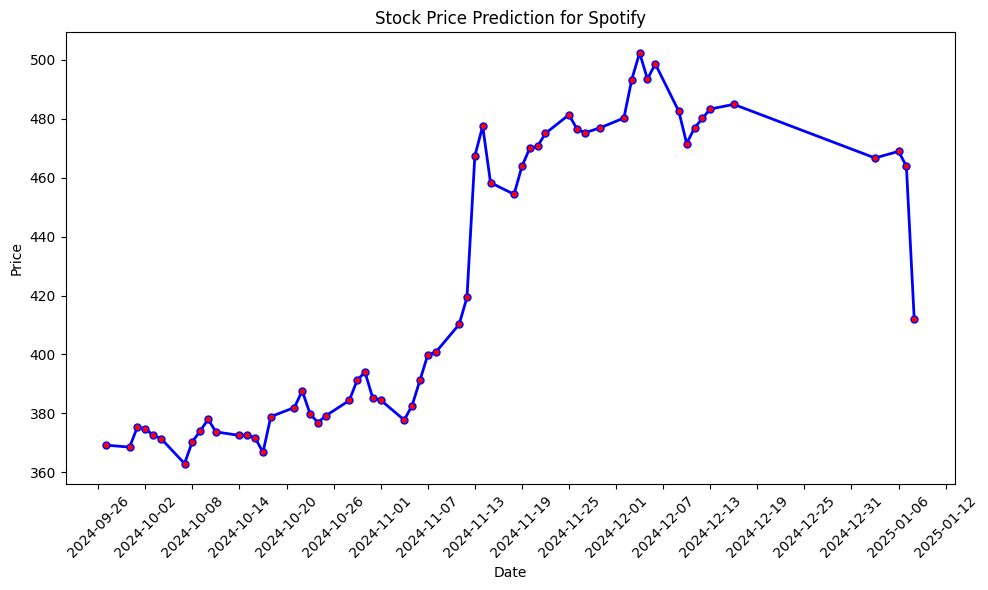

In [22]:
file_path = "../docs/img/spot_forecast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=spot_plotting_df.head(60), file_path=file_path, name="Spotify", hindcast=False) 
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=spot_plotting_df.head(60), file_path=file_path, name="Spotify", hindcast=False) 

plt.show()

In [23]:
googl_df = GOOGL_fg.read()
googl_df['timestamp'] = pd.to_datetime(googl_df['timestamp'].dt.date)

googl_plotting_df = pd.DataFrame()
googl_plotting_df['predicted_price'] = googl_df['price']
googl_plotting_df['timestamp'] = googl_df['timestamp']
googl_plotting_df = pd.concat([googl_plotting_df, googl_pred_df], ignore_index=True)
googl_plotting_df['date'] = googl_plotting_df['timestamp'].copy()
googl_plotting_df.drop('timestamp', axis=1, inplace=True)
googl_plotting_df = googl_plotting_df.sort_values(by=['date'], ascending=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.39s) 


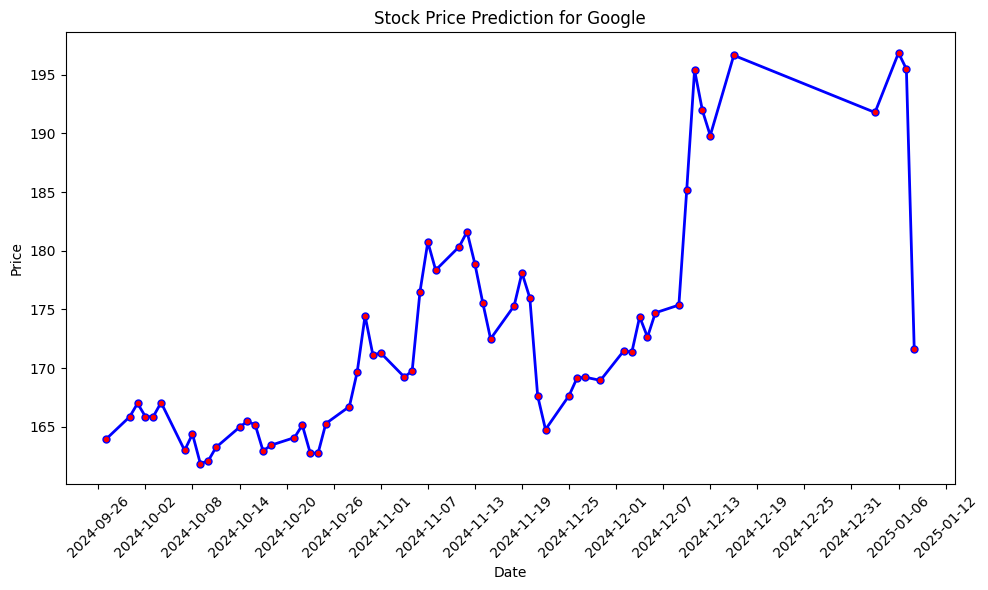

In [24]:
file_path = "../docs/img/googl_forecast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=googl_plotting_df.head(60), file_path=file_path, name="Google", hindcast=False) 
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=googl_plotting_df.head(60), file_path=file_path, name="Google", hindcast=False) 

plt.show()

In [25]:
btc_df = BTC_fg.read()
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'].dt.date)

btc_plotting_df = pd.DataFrame()
btc_plotting_df['predicted_price'] = btc_df['price']
btc_plotting_df['timestamp'] = btc_df['timestamp']
btc_plotting_df = pd.concat([btc_plotting_df, btc_pred_df], ignore_index=True)
btc_plotting_df['date'] = btc_plotting_df['timestamp'].copy()
btc_plotting_df.drop('timestamp', axis=1, inplace=True)
btc_plotting_df = btc_plotting_df.sort_values(by=['date'], ascending=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


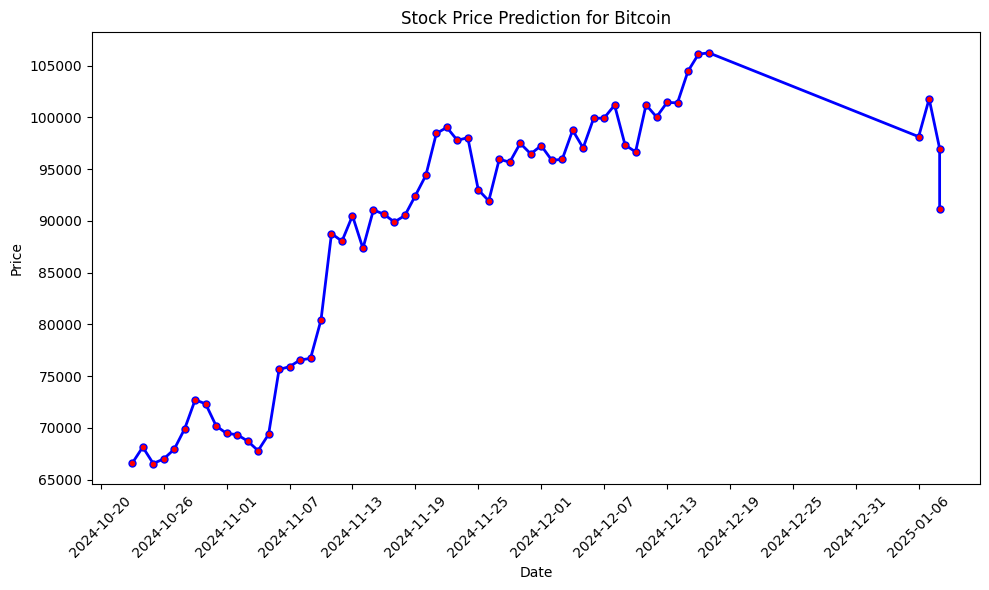

In [26]:
file_path = "../docs/img/btc_forecast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=btc_plotting_df.head(60), file_path=file_path, name="Bitcoin", hindcast=False) 
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=btc_plotting_df.head(60), file_path=file_path, name="Bitcoin", hindcast=False) 

plt.show()

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [27]:
SPOT_pred_df = spot_pred_fg.read()
# Convert timestamps to datetime and set timezone to UTC
SPOT_pred_df['timestamp'] = SPOT_pred_df['timestamp'].dt.tz_localize(None)
spot_df['timestamp'] = spot_df['timestamp'].dt.tz_localize(None)
merged_SPOT_df = pd.merge(SPOT_pred_df, spot_df, on='timestamp', how='inner')
merged_SPOT_df['date'] = merged_SPOT_df['timestamp'].copy()
merged_SPOT_df.drop('timestamp', axis=1, inplace=True)
merged_SPOT_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.44s) 


,predicted_price,price,date
0,423.199097,468.93,2025-01-06
1,423.199097,463.93,2025-01-07


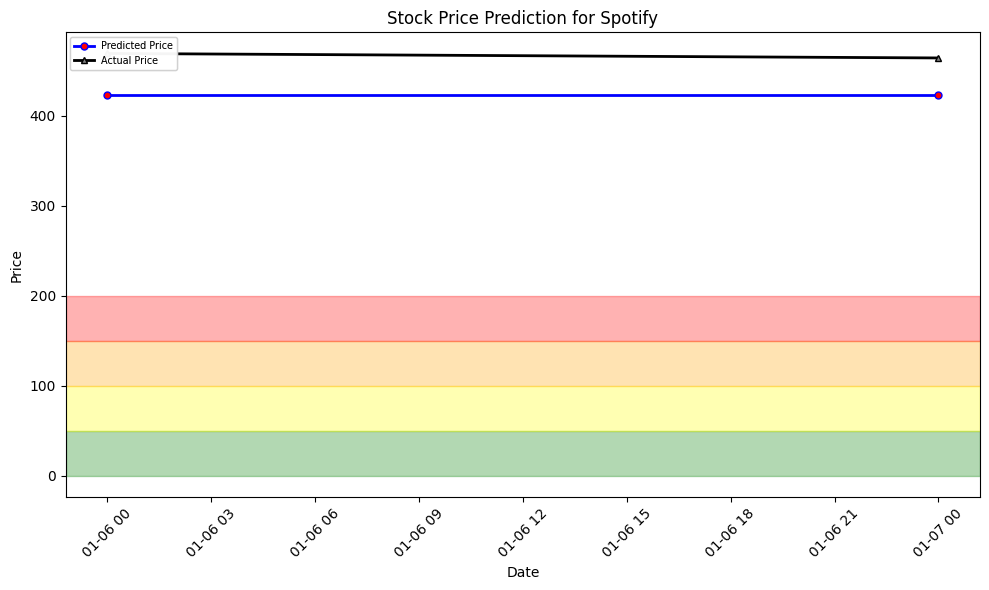

In [28]:
file_path = "../docs/img/spot_hindcast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=merged_SPOT_df, file_path=file_path, name="Spotify", hindcast=True)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=merged_SPOT_df, file_path=file_path, name="Spotify", hindcast=True)

plt.show()

In [29]:
GOOGL_pred_df = googl_pred_fg.read()
# Convert timestamps to datetime and set timezone to UTC
GOOGL_pred_df['timestamp'] = GOOGL_pred_df['timestamp'].dt.tz_localize(None)
googl_df['timestamp'] = googl_df['timestamp'].dt.tz_localize(None)
merged_GOOGL_df = pd.merge(GOOGL_pred_df, googl_df, on='timestamp', how='inner')
merged_GOOGL_df['date'] = merged_GOOGL_df['timestamp'].copy()
merged_GOOGL_df.drop('timestamp', axis=1, inplace=True)
merged_GOOGL_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.47s) 


,predicted_price,price,date
0,171.627686,196.87,2025-01-06
1,171.627686,195.49,2025-01-07


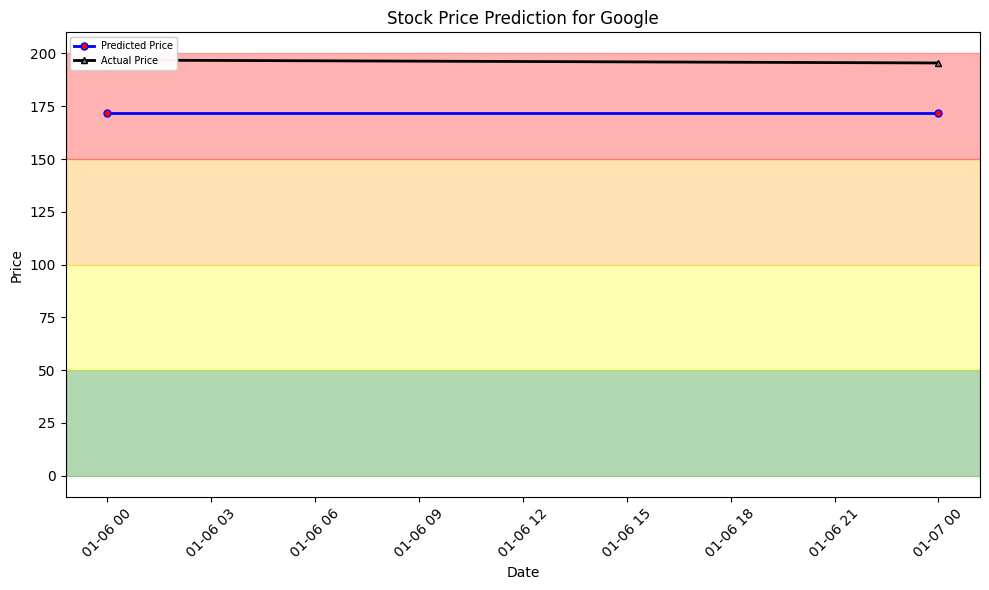

In [30]:
file_path = "../docs/img/googl_hindcast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=merged_GOOGL_df, file_path=file_path, name="Google", hindcast=True)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=merged_GOOGL_df, file_path=file_path, name="Google", hindcast=True)

plt.show()

In [31]:
BTC_pred_df =btc_pred_fg.read()
# Convert timestamps to datetime and set timezone to UTC
BTC_pred_df['timestamp'] = BTC_pred_df['timestamp'].dt.tz_localize(None)
btc_df['timestamp'] = btc_df['timestamp'].dt.tz_localize(None)
merged_BTC_df = pd.merge(BTC_pred_df, btc_df, on='timestamp', how='inner')
merged_BTC_df['date'] = merged_BTC_df['timestamp'].copy()
merged_BTC_df.drop('timestamp', axis=1, inplace=True)
merged_BTC_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 


,predicted_price,price,date
0,93871.054688,98130.00,2025-01-06
1,98411.734375,101784.17,2025-01-07


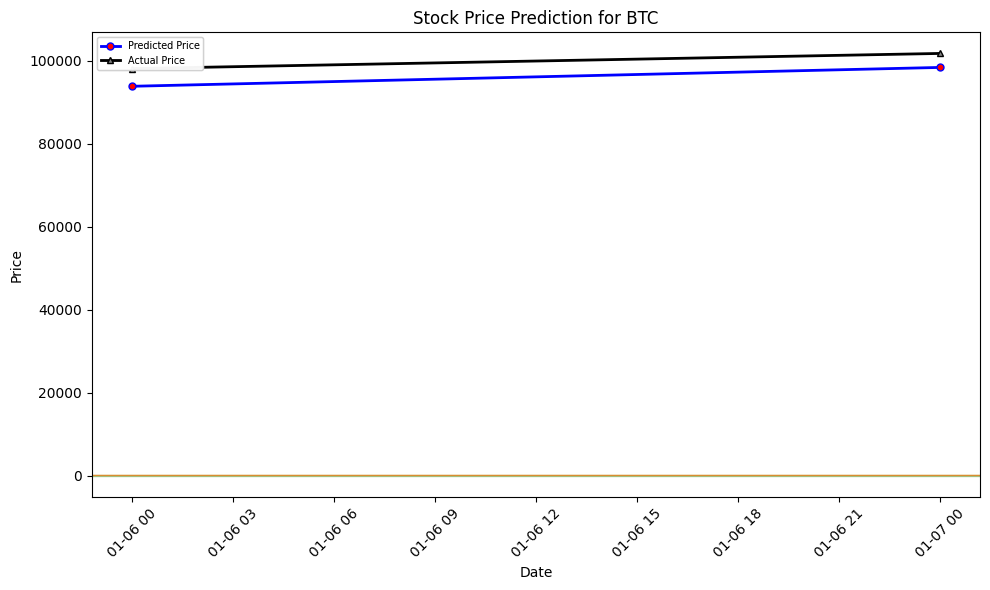

In [32]:
file_path = "../docs/img/btc_hindcast.png"
if os.path.exists(os.path.dirname(file_path)):
    plt = util.plot_stock_price_forecast(df=merged_BTC_df, file_path=file_path, name="BTC", hindcast=True)
else:
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt = util.plot_stock_price_forecast(df=merged_BTC_df, file_path=file_path, name="BTC", hindcast=True)

plt.show()